# Exam project: Investigating the remote labour market in Denmark

This notebook is used for webscraping www.jobindex.dk for job postings in the period 2010-2020.
The notebook includes all code used for collecting and cleaning data, making graphs, tables, text analysis and forecasting.

In [1]:
# Import necessary modules
import re
import requests
import numpy as np
import pandas as pd
import math
import time
from bs4 import BeautifulSoup
from datetime import datetime
import PyPDF2 
import textract
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import slate3k as slate
import certifi #pip install certifi
import urllib3 #pip install urllib3[secure]
http = urllib3.PoolManager()
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import colors as mcolors
import seaborn as sns 
%matplotlib inline
import langdetect 
import nltk
from langdetect import detect #pip install langdetect

#Make log
import scraping_class
logfile = 'log_jobindex_scraping.txt'
connector = scraping_class.Connector(logfile)

#Define todays date and enddate for data
from datetime import date
today = date.today().strftime("%Y%m%d") # to get format 20080101
start = '20100101'

#Define path to folder
path = (r'C:\Users\miche\Dropbox\KU Introduction to Social Data Science\Modules')

### Web-scraping job postings from Jobindex
##### Geographical region and job category
www.jobindex.dk/jobsoegning has filters for geographical area and job category, respectively. We will scrape this to be able to describe in which areas and industries remote working is especially taking place. 
The address of the company is also attached to the job posting, and even though this information would be more detailed, we have experienced that the address often belongs to the headquarter of the company and not the specific area, where the job is. Therefore we use the information from the geographical filter.

In [2]:
#Define the basic url
url = 'https://www.jobindex.dk/jobsoegning'
response = requests.get(url)
html = response.text
soup = BeautifulSoup(html,'lxml')

#Areas are given in the html by div id=areas and class=area_label
areas_html = soup.find('div', {'id':'areas'})#('a', {'class':'area_label'})
areas_div = str(areas_html).split('href="/jobsoegning/')[1:]

#Find the names of each of the areas
areas = () #we make a tuple, so we can order it
areas_delete = ('skaane', 'faeroeerne', 'udlandet', 'groenland', 'danmark') #delete regions outside Denmark's borders
for area in areas_div:
    link = area.split('"')[0]
    if link in areas_delete:
        del link
    else:
        areas += (link,)
areas += ('danmark',) #make sure Danmark is the last element in the tuple. 
#print(areas)

#Categories are given in the html by and id=categories
cat_html = soup.find('div', {'id':'categories'})
cat_div = soup.find_all('a',{'class':'filter-section-header title collapsed'}) #the filter collapses

categories = []
subcategories = []
for cat in cat_div:
    #first find the overall categories
    cat_name = re.findall(r'(?<=<span>)(.*)(?=<span class)', str(cat))[0]
    cat_name = cat_name.replace('\xad','')
    cat_links = re.findall("href=[\"\'](.*?)[\"\']", str(cat))
    cat_id = str(cat_links[0])
    cat_id = cat_id.replace('#','')
    category = [cat_name,cat_id]
    categories.append(category)
    #next find the sub-categories
    subcat_div = str(cat_html).split('href="/jobsoegning/')[1:]
for subcat in subcat_div:
    subcategory = subcat.split('"')[0]
    subcategories.append(subcategory)
#print(categories)
#print(subcategories)

##### Defining "remote job postings"
We define a string of words and phrases related to working remotely to search through Jobindex for remote job postings. We include both Danish and English words/phrases, as we have experienced a lot of English job postings in bigger companies.
We started out by trying to webscrape all job postings over the period and would have labeled remote/not remote afterwards, however there was approx. 3 million job postings and the scraping would take days. Instead we scrape the details of the relevant job postings and scrape the sum of the rest to be able to report relative numbers (although they are not perfect).

##### Number of postings and pages
Each page of www.jobindex.dk/jobsoegning contains 20 joblistings. Since the number of job postings differ from time to time, so does the number of pages. To be able to scrape job postings on all pages, we look at the pagination and find the max page.

In [92]:
#Define the search words in jobindex for working remotely
remotely = ['hjemmekontor','hjemmearbejde','fjernarbejde','arbejde%2Bhjemmefra','arbejde%2Bhjemme','remote%2Barbejdsplads','remote%2Bwork','work%2Bremotely', 'working%2Bremotely','working%2Bfrom%2Bhome', 'home%2Boffice','home-office']

#Scraping in loops from jobindex.
jobs = []
for area in areas:
    for subcategory in subcategories:
        print('Now requesting url: ' + subcategory +' and '+ area)
        for remote in remotely:
            url = f'https://www.jobindex.dk/jobsoegning/{subcategory}/{area}?jobage=archive&maxdate={today}&mindate={start}&q={remote}'
            response = requests.get(url) 
            soup = BeautifulSoup(response.text,'lxml')
        
            #Identify total number of job postings in the given quarter
            pages = BeautifulSoup(str(soup.find_all("div", {'class':'jix_pagination_total'}))).get_text() 
            total = re.findall(r'af(?s)(.*)resultat',str(pages))
            total = str(total).strip("[]").strip("''").strip().replace('.','')
            if total == 0:
                continue
            #Use total number of job postings to calculate total number of pages
            last_page = math.ceil(int(total)/20)
        
            #Loop through pages
            for page in range(1,last_page+1):
                if  page % 20 == 0:
                    print('Now scraping page: ',page,'/', last_page, ' for ', subcategory, ' and ', area)
                url = f'https://www.jobindex.dk/jobsoegning/{subcategory}/{area}?jobage=archive&maxdate={today}&mindate={start}&page={page}&q={remote}'
                response = requests.get(url)  
                html = response.text   
                if '<strong>' in html: 
                    html = html.replace('<strong>','<b>')\
                                .replace('</strong>','</b>')
                else:
                    print('No <strong>')
                soup = BeautifulSoup(html,'lxml') 
                joblistings = soup.find_all('div',{'class':'jobsearch-result'}) 
                        
                for joblisting in joblistings: #Loop through job listings
                    #Find title
                    title = re.findall(r'(?<=<b>)(.*)(?=</b>)', str(joblisting))[0]
                    title = title.replace('amp;','')
                    #Find company name
                    if len(re.findall(r'(?<=<b>)(.*)(?=</b>)', str(joblisting)))>1:
                        company = re.findall(r'(?<=<b>)(.*)(?=</b>)', str(joblisting))[1]
                        company = company.replace('amp;','')\
                                            .replace('<b>','')\
                                            .replace('</b>','') 
                    #Find publication date
                    pub_date = re.findall(r'time\sdatetime="(.*)"', str(joblisting))[0]
                    geo_area = area #Save geographical area
                    cat_id = re.findall('(.*?)/', str(subcategory))[0] #Save category 
                    subcat_id = subcategory #Save subcategory
                    remote_word = remote
                    #Find link to job posting
                    descrip = BeautifulSoup(str(joblisting), 'lxml')
                    for div in descrip.find_all("div", {'class':'jix_toolbar jix_appetizer_toolbar'}): # remove toolbar at the end of each job
                        div.decompose()
                    for span in descrip.find_all("span", {'class':'jix_toolbar jix_appetizer_toolbar'}): # remove toolbar at the end of each job
                        span.decompose()
                    links = re.findall("href=[\"\'](.*?)[\"\']", str(descrip))
                    if len(links)>1:
                        link = str(links[1])
                    else:
                        link = str(links[0])
                    link = link.replace("&amp;", "&")
                    # Indirectly extracting the short job description by removing everything else
                    descrip = descrip.get_text()
                    descrip = descrip.replace("\n", " ") # remove \n
                    job = [title, company, pub_date, remote_word, geo_area, cat_id, subcat_id, link, descrip]
                    jobs.append(job)
    df = pd.DataFrame(jobs)
    df.columns = ['Job Title','Company','Publication Date','Remote word','Geographical Area','Job Category','Job Subcategory', 'Link', 'Description']
    df.to_pickle(path+'\Jobs_basic_info_10-20')
    print('Finished area: ',area)
 

Now requesting url: it/database and sydjylland
Now requesting url: it/itdrift and sydjylland
Now requesting url: it/itkurser and sydjylland
Now requesting url: it/itledelse and sydjylland
Now requesting url: it/internet and sydjylland
Now requesting url: it/systemudvikling and sydjylland
Now requesting url: it/telekom and sydjylland
Now requesting url: it/virksomhedssystemer and sydjylland
Now requesting url: ingenioer/byggeteknik and sydjylland
Now requesting url: ingenioer/elektronik and sydjylland
Now requesting url: ingenioer/kemi and sydjylland
Now requesting url: ingenioer/teknikledelse and sydjylland
Now requesting url: ingenioer/maskiningenioer and sydjylland
Now requesting url: ingenioer/medicinal and sydjylland
Now requesting url: ingenioer/produktionsteknik and sydjylland
Now requesting url: ledelse/detailledelse and sydjylland
Now requesting url: ledelse/freelancekonsulent and sydjylland
Now requesting url: ledelse/hrkurser and sydjylland
Now requesting url: it/itledelse an

Now requesting url: industri/toemrer and bornholm
Now requesting url: salg/design and bornholm
Now requesting url: salg/ejendomsmaegler and bornholm
Now requesting url: salg/grafisk and bornholm
Now requesting url: salg/kommunikation and bornholm
Now requesting url: salg/kultur and bornholm
Now requesting url: salg/marketing and bornholm
Now requesting url: salg/salg and bornholm
Now requesting url: salg/salgskurser and bornholm
Now requesting url: ledelse/salgschef and bornholm
Now requesting url: salg/franchise and bornholm
Now requesting url: salg/telemarketing and bornholm
Now requesting url: undervisning/bibliotek and bornholm
Now requesting url: undervisning/forskning and bornholm
Now requesting url: ledelse/institutions and bornholm
Now requesting url: undervisning/laerer and bornholm
Now requesting url: undervisning/paedagog and bornholm
Now requesting url: undervisning/voksenuddannelse and bornholm
Now requesting url: kontor/akademisk and bornholm
Now requesting url: salg/ejen

Now scraping page:  40 / 57  for  oevrige/student  and  danmark
Now requesting url: oevrige/studiepraktik and danmark
Now requesting url: oevrige/oevrige and danmark
Now requesting url: oevrige/kurseroevrige and danmark
Finished area:  danmark


### Cleaning the data for final dataset
We clean the data for duplicate observations from scraping url's, that may contain some of the same job postings. It is done in steps to be able to report the proces in our paper.


In [4]:
#Read the three datafiles scraped from Jobindex
unpickled1 = pd.read_pickle(path+'\Jobs_basic_info')
unpickled2 = pd.read_pickle(path+'\Jobs_basic_info_10rest') 
unpickled3 = pd.read_pickle(path+'\Jobs_basic_info_10rest2')
unpickled_df = pd.concat([unpickled1,unpickled2,unpickled3])
#print(unpickled_df.columns)
print('Length of dataset: ',len(unpickled_df)) 

#Change variables
unpickled_df['Remote'] = 1
unpickled_df['Publication Date'] = pd.to_datetime(unpickled_df['Publication Date'], format='%Y-%m-%d').dt.to_period('M')
unpickled_df['Year'] = unpickled_df['Publication Date'].dt.strftime('%Y')
unpickled_df['Date'] = unpickled_df['Publication Date'].dt.strftime('%Y%m%d')
unpickled_df['Month-Year'] = unpickled_df['Publication Date'].dt.strftime('%b-%Y')

#Report how many obs in each [remote word] for data description
count_remote_word = pd.DataFrame(unpickled_df.groupby('Remote word')['Remote'].sum()).reset_index()
print(count_remote_word)   

#Removing duplicated step by step
#Dropping completely duplicte entries 
dupl1 = unpickled_df.drop_duplicates(keep = 'first')
print('Length after dropping all complete duplicates: ', len(dupl1))

#Drop duplicate entries based on all columns besides remote word (=> same job posting could occur in multiple searchings)
dupl2 = dupl1.drop_duplicates(subset=['Job Title','Company','Publication Date','Geographical Area','Job Category','Job Subcategory','Link','Description'], keep = 'first')
print('Length after dropping duplicates on remote word: ',len(dupl2))

#Drop duplicate entries based on all columns besides category and subcategory (=> same job could occur in more categories)
dupl3 = dupl2.drop_duplicates(subset=['Job Title','Company','Publication Date','Geographical Area','Link','Description'], keep = 'first')
print('Length after dropping duplicates on category and subcategory: ',len(dupl3))

#Drop duplicate entries based on all columns besides remote word and geographical area (=> same job could occur)
#Be aware that the same job posting can be in more areas
dupl4 = dupl3.drop_duplicates(subset=['Job Title','Company','Publication Date','Link','Description'], keep = 'first')
print('Length after dropping duplicates on geographical area: ',len(dupl4))

######FINAL DATA###########################################################################################
final_data = dupl4.copy()

#Save final data frame
#final_data.to_pickle(path + '\final_data.pkl')
#final_data.to_csv(path +'\final_data.csv')
############################################################################################################

Length of dataset:  54281
              Remote word  Remote
0        arbejde%2Bhjemme    3688
1     arbejde%2Bhjemmefra   15462
2            fjernarbejde      90
3           hjemmearbejde    4882
4            hjemmekontor   16370
5           home%2Boffice    4190
6             home-office    4190
7   remote%2Barbejdsplads      29
8           remote%2Bwork    1119
9         work%2Bremotely    1065
10  working%2Bfrom%2Bhome    2564
11     working%2Bremotely     632
Length after dropping all complete duplicates:  52193
Length after dropping duplicates on remote word:  47117
Length after dropping duplicates on category and subcategory:  36119
Length after dropping duplicates on geographical area:  14717


## Scraping total number of job postings from Jobindex
Since we were not able to scrape the details of all job postings, because the scraping would have taken days to run, we have scraped the remote job postings with details and will scrape the total number of job postings on a given date to ba able to report relative numbers.
To get the least amount of duplicates, we scrape the total number of job postings on a given date/month alone, for each area and for each category.

1. First, we scrape the total number of jobs posted DAILY from 2010-2020
2. Second, we scrape the total number of jobs posted MONTHLY from 2010-2020 in each area
3. Third, we scrape the total number of jobs posted MONTHLY from 2010-2020 in each subcategory

In [3]:
#Define a list of daily dates from 2010 until today
datelist = pd.date_range(start=start, end=today, freq='D').date.tolist()
datelist = [str(date).strip("()").strip("datetime.date").replace(',','').replace('-','') for date in datelist]
print(datelist[1:10])

#Define the date lists of months from 2020 until today
start_date = pd.date_range(start,'2020-09-01', freq='1M')-pd.offsets.MonthBegin(1)
start_date = [str(date).strip("()").strip("datetime.date").replace(',','').replace('-','').replace(':','').strip(' 000000') for date in start_date]

end_date = pd.date_range(start,'2020-10-01', freq='1M')
end_date = [str(date).strip("()").strip("datetime.date").replace(',','').replace('-','').replace(':','').strip('000000').rstrip() for date in end_date]

def merge(list1, list2): 
    merged_list = tuple(zip(list1, list2))  
    return merged_list 
month_dates = merge(start_date,end_date)
print(month_dates[1:10])

['20100102', '20100103', '20100104', '20100105', '20100106', '20100107', '20100108', '20100109', '20100110']
(('20100201', '20100228'), ('20100301', '20100331'), ('20100401', '20100430'), ('20100501', '20100531'), ('20100601', '20100630'), ('20100701', '20100731'), ('20100801', '20100831'), ('20100901', '20100930'), ('20101001', '20101031'))


##### 1. Daily: total number of job postings posted on each date

In [120]:
#Scrape total number of job postings posted on each date
date_totals = []
for date in datelist:
    print('Has now reached date: '+date)
    url = f'https://www.jobindex.dk/jobsoegning?maxdate={date}&mindate={date}&jobage=archive'
    response = requests.get(url) 
    soup = BeautifulSoup(response.text,'lxml')
    search_results = BeautifulSoup(str(soup.find_all("div", {'class':'jix_pagination_total'}))).get_text()
    total = re.findall(r'af(?s)(.*)resultat',str(search_results))
    total = str(total).strip("[]").strip("''").strip().replace('.','')
    if total == 0:
            continue
    #Use total number of job postings to calculate total number of pages
    total=int(total)
    t_d = [date,total]
    date_totals.append(t_d)
    
totals = pd.DataFrame(date_totals)
totals.columns = ['Date','Postings Published']
totals.to_pickle(path+'\Total_jobs_daily10-20.pkl')

['19691231', '19700101', '19700102', '19700103', '19700104', '19700105', '19700106', '19700107', '19700108', '19700109', '19700110', '19700111', '19700112', '19700113', '19700114', '19700115', '19700116', '19700117', '19700118', '19700119', '19700120', '19700121', '19700122', '19700123', '19700124', '19700125', '19700126', '19700127', '19700128', '19700129', '19700130', '19700131', '19700201', '19700202', '19700203', '19700204', '19700205', '19700206', '19700207', '19700208', '19700209', '19700210', '19700211', '19700212', '19700213', '19700214', '19700215', '19700216', '19700217', '19700218', '19700219', '19700220', '19700221', '19700222', '19700223', '19700224', '19700225', '19700226', '19700227', '19700228', '19700301', '19700302', '19700303', '19700304', '19700305', '19700306', '19700307', '19700308', '19700309', '19700310', '19700311', '19700312', '19700313', '19700314', '19700315', '19700316', '19700317', '19700318', '19700319', '19700320', '19700321', '19700322', '19700323', '19

'\n#Scrape total number of job postings posted on each date\ndate_totals = []\nfor date in datelist:\n    print(\'Has now reached date: \'+date)\n    url = f\'https://www.jobindex.dk/jobsoegning?maxdate={date}&mindate={date}&jobage=archive\'\n    response = requests.get(url) \n    soup = BeautifulSoup(response.text,\'lxml\')\n    search_results = BeautifulSoup(str(soup.find_all("div", {\'class\':\'jix_pagination_total\'}))).get_text()\n    total = re.findall(r\'af(?s)(.*)resultat\',str(search_results))\n    total = str(total).strip("[]").strip("\'\'").strip().replace(\'.\',\'\')\n    if total == 0:\n            continue\n    #Use total number of job postings to calculate total number of pages\n    total=int(total)\n    t_d = [date,total]\n    date_totals.append(t_d)\n    \ntotals = pd.DataFrame(date_totals)\ntotals.columns = [\'Date\',\'Postings Published\']\ntotals.to_pickle(path+\'\\Total_jobs_daily10-20.pkl\')'

##### 2. Month, Area: Yotal number of job postings each month for each area

In [ ]:
#Scrape total number of job postings each month for each area
date_totals_area = []
         
for area in areas:
    print('Has now reached area: '+area )
    for date in month_dates:
        url = f'https://www.jobindex.dk/jobsoegning/{area}?maxdate={date[1]}&mindate={date[0]}&jobage=archive'
        response = requests.get(url) 
        soup = BeautifulSoup(response.text,'lxml')
        search_results = BeautifulSoup(str(soup.find_all("div", {'class':'jix_pagination_total'}))).get_text()
        total = re.findall(r'af(?s)(.*)resultat',str(search_results))
        total = str(total).strip("[]").strip("''").strip().replace('.','')
        if total == 0:
                continue
        #Use total number of job postings to calculate total number of pages
        total=int(total)
        month = pd.date_range(date[0], date[1], freq='MS').strftime("%b-%Y").tolist()
        t_d = [month,area,total]
        date_totals_area.append(t_d)

totals_cat_area = pd.DataFrame(date_totals_area)
totals_cat_area.columns = ['Month-Year','Area','Postings Published']
totals_cat_area.to_pickle(path+'\Total_jobs_month_area10-20.pkl')

Has now reached area: storkoebenhavn
Has now reached area: nordsjaelland
Has now reached area: region-sjaelland


##### 2010, 2019, 2020, Area: Total number of job postings in 2010, 2019 and 2020 for each area

In [342]:
date_totals_area = []
         
for area in areas:
    for date in ('2010','2019','2020'):
        print('Has now reached area/year: '+ area + date )
        url = f'https://www.jobindex.dk/jobsoegning/{area}?maxdate={date}1231&mindate={date}0101&jobage=archive'
        response = requests.get(url) 
        soup = BeautifulSoup(response.text,'lxml')
        search_results = BeautifulSoup(str(soup.find_all("div", {'class':'jix_pagination_total'}))).get_text()
        total = re.findall(r'af(?s)(.*)resultat',str(search_results))
        total = str(total).strip("[]").strip("''").strip().replace('.','')
        if total == 0:
                continue
        #Use total number of job postings to calculate total number of pages
        total=int(total)
        year = date
        t_d = [year,area,total]
        date_totals_area.append(t_d)

totals_cat_area = pd.DataFrame(date_totals_area)
totals_cat_area.columns = ['Year','Area','Postings Published']
totals_cat_area.to_pickle(path+'\Total_jobs_year_area101920.pkl')

Has now reached area/year: storkoebenhavn2010
Has now reached area/year: storkoebenhavn2019
Has now reached area/year: storkoebenhavn2020
Has now reached area/year: nordsjaelland2010
Has now reached area/year: nordsjaelland2019
Has now reached area/year: nordsjaelland2020
Has now reached area/year: region-sjaelland2010
Has now reached area/year: region-sjaelland2019
Has now reached area/year: region-sjaelland2020
Has now reached area/year: fyn2010
Has now reached area/year: fyn2019
Has now reached area/year: fyn2020
Has now reached area/year: region-nordjylland2010
Has now reached area/year: region-nordjylland2019
Has now reached area/year: region-nordjylland2020
Has now reached area/year: region-midtjylland2010
Has now reached area/year: region-midtjylland2019
Has now reached area/year: region-midtjylland2020
Has now reached area/year: sydjylland2010
Has now reached area/year: sydjylland2019
Has now reached area/year: sydjylland2020
Has now reached area/year: bornholm2010
Has now reac

##### 3. Month, Subcategory: Total number of job postings each month for each subcategory

In [ ]:
#Scrape total number of job postings each month for each subcategory
date_totals_subcat = []

for subcategory in subcategories:
    print('Has now reached subcategory: '+subcategory)
    for date in month_dates:
        url = f'https://www.jobindex.dk/jobsoegning/{subcategory}?jobage=archive&maxdate={date[1]}&mindate={date[0]}'
        response = requests.get(url) 
        soup = BeautifulSoup(response.text,'lxml')
        search_results = BeautifulSoup(str(soup.find_all("div", {'class':'jix_pagination_total'}))).get_text()
        total = re.findall(r'af(?s)(.*)resultat',str(search_results))
        total = str(total).strip("[]").strip("''").strip().replace('.','')
        if total == 0:
                continue
        total=int(total)
        month = pd.date_range(date[0], date[1], freq='MS').strftime("%b-%Y").tolist()
        category = re.findall('(.*?)/', str(subcategory))[0]
        t_d = [month,category,subcategory,total]
        date_totals_subcat.append(t_d)
        
totals_subcat = pd.DataFrame(date_totals_subcat)
totals_subcat.columns = ['Month-Year','Job Category','Job Subcategory','Postings Published']
totals_subcat.to_pickle(path+'Total_jobs_month_subcategory10-20')
#totals_cats = pd.concat([totals_subcat, totals_cat]).drop_duplicates()

# Graphs for descriptive analysis
This part of the notebook prepares the dataframe for the different graphs and makes the graphs

First we make dataframes for different kind of data we need for the graphs.
We then make the different graphs and save them to put in the report.

In [5]:
#Make lists of dates, areas, categories and subcategories
#all unique dates
dates = pd.DataFrame(pd.date_range(start=start, end=today, freq='D').strftime("%Y%m%d").tolist())
dates = dates.iloc[pd.to_datetime(dates.index).argsort()] #sort
dates.columns = ['Date']

#all unique month-year
months = pd.DataFrame(pd.date_range(start=start, end=today, freq='MS').strftime("%b-%Y").tolist()) 
months = months.iloc[pd.to_datetime(months.index).argsort()] #sort
months.columns = ['Month-Year']
#monthlist = [str(date).strip("()").strip("datetime.date").replace(',','') for date in monthlist]

#all unique areas
areas = pd.DataFrame(np.unique(final_data['Geographical Area']))
areas.columns = ['Geographical Area']

#all unique categories
categories = pd.DataFrame(np.unique(final_data['Job Category']))
categories.columns = ['Job Category']

#all unique subcategories
subcategories = pd.DataFrame(np.unique(final_data['Job Subcategory']))
subcategories.columns = ['Job Subcategory']

#Translate job categories
final_data['Job Category'] = final_data['Job Category'].replace(['it','ingenioer','ledelse','handel','industri','salg','undervisning','kontor','social','oevrige'],['Information Technology','Engineering and technology','Management and staff','Trade and service','Industry and craft','Sales and communication','Teaching','Office and finance','Social and health','Other positions'])



##### Figure 1
Shows the actual number of remote job postings on Jobindex at a given point in time in the period 2015-2020. The bars are further split into job categories (industries).'''

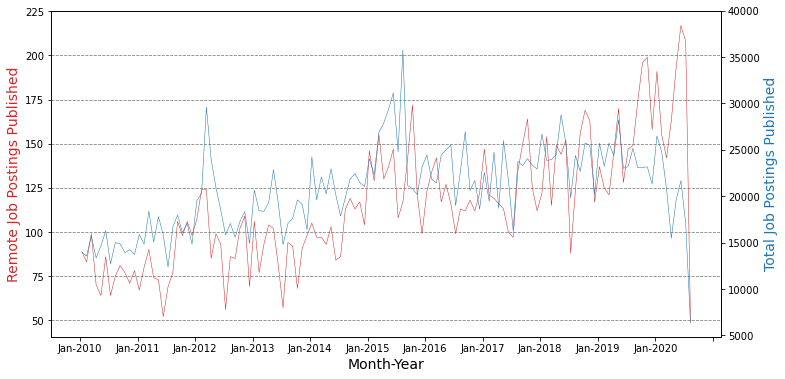

In [22]:
#Count the number of remote job postings per month-year with groupby
total_remote_date = pd.DataFrame(final_data.groupby('Month-Year')['Remote'].sum()).reset_index()
total_remote_date.columns = ['Month-Year','Remote Postings Published']

#Total number of job postings in the period
total_date = pd.read_pickle(path+'\Total_jobs_daily10-20.pkl')
total_date['Month-Year'] = pd.to_datetime(total_date['Date'], format='%Y%m%d').dt.to_period('M')
total_date['Month-Year'] = total_date['Month-Year'].dt.strftime('%b-%Y')
total_date = pd.DataFrame(total_date.groupby('Month-Year')['Postings Published'].sum()).reset_index()

#Merge all together
fig1a = pd.merge(months, total_remote_date, on='Month-Year', how='left')
fig1a = pd.merge(fig1a, total_date, on='Month-Year', how='left')
#remote_date.to_pickle(path+'xxx') #save the dataframe

#FIGURE 1a
fig,ax = plt.subplots(figsize=(12,6))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
ax.plot(fig1a['Month-Year'],fig1a['Remote Postings Published'], color=colors[3], linewidth=0.5)
# set x-axis label
ax.set_xlabel("Month-Year",fontsize=14)

# set y-axis label
ax.set_ylabel("Remote Job Postings Published",color=colors[3],fontsize=14)
ax.set_yticks(np.arange(50, 225+1, 25))

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(fig1a['Month-Year'],fig1a['Postings Published'],color=colors[0], linewidth=0.5)
ax2.set_ylabel("Total Job Postings Published",color=colors[0],fontsize=14)

#grid
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')

#ticks
ax2.set_yticks(np.arange(5000, 40000+1, 5000))
start, stop = ax.get_xlim()
plt.xticks(np.arange(start+6, stop+1, 12), rotation=40)

#save graph
plt.show()
fig.savefig('fig1a.png')


##### Figure 2
Figure 1b shows the percentage of remote job postings relative to the total number of job postings on Jobindex 
at a given point in time in the period 2015-2020. The bars are further split into job categories (industries).

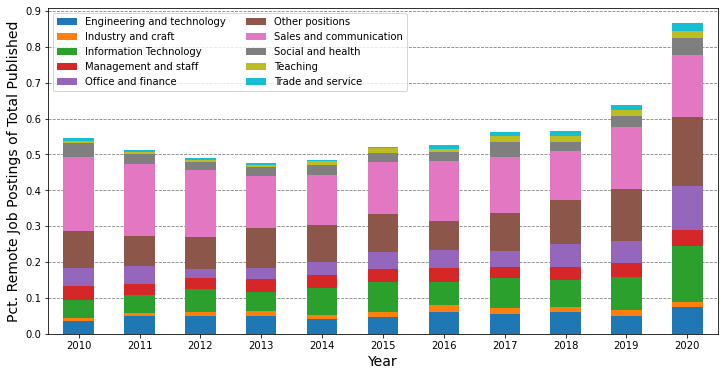

In [20]:
#Make monthly data into year-level data
fig1a['Year'] = fig1a['Month-Year'].str.split('-', 1).str[1]
fig1b = pd.DataFrame(fig1a.groupby(['Year']).sum()).reset_index()

#Yearly total job postings
remote_category_year = pd.DataFrame(final_data.groupby(['Year','Job Category'])['Remote'].sum()).reset_index()
remote_category_year.columns = ['Year','Job Category','Remote Postings Published']
#print(remote_category_year)

#Merge
fig1b = pd.merge(remote_category_year, fig1b, on='Year', how='left')
fig1b['Pct. Remote Job Postings of Total Published'] = (fig1b['Remote Postings Published_x']/fig1b['Postings Published'])*100

#Stacked histogram
fig, ax = plt.subplots(figsize=(12,6))  
month = fig1b['Job Category'].drop_duplicates()
margin_bottom = np.zeros(len(fig1b['Year'].drop_duplicates()))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for num, m in enumerate(month):
    values = list(fig1b[fig1b['Job Category'] == m].loc[:, 'Pct. Remote Job Postings of Total Published'])
    fig1b[fig1b['Job Category'] == m].plot.bar(x='Year',y='Pct. Remote Job Postings of Total Published', ax=ax, stacked=True, 
                                    bottom = margin_bottom, color=colors[num], label=m)
    margin_bottom += values
ax.set_xlabel('Year',fontsize=14)
ax.set_ylabel('Pct. Remote Job Postings of Total Published',fontsize=14)
plt.yticks(np.arange(0.0, 1.0, 0.1))
plt.xticks(rotation=0)
plt.legend(ncol=2)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.show()
fig.savefig('fig1b.png')


#####  Figure 3: Denmark maps
Figure 3 shows the percentage of remote job postings in different Danish regions in 2010, 2019 and 2020.

In [ ]:
#Total number of job postings in the period
total_year = pd.read_pickle(path+'\Total_jobs_year_area101920.pkl')
total_year['Area'] = total_year['Area'].replace('nordsjaelland','storkoebenhavn') #to sum the two regions
total_year = pd.DataFrame(total_year.groupby(['Year','Area'])['Postings Published'].sum()).reset_index()

#Count the number of remote job postings per month-year for each region
area_remote_year = final_data.copy()
area_remote_year['Geographical Area'] = area_remote_year['Geographical Area'].replace('nordsjaelland','storkoebenhavn') #sum the two regions
area_remote_year = pd.DataFrame(area_remote_year.groupby(['Year','Geographical Area'])['Remote'].sum()).reset_index()
area_remote_year.columns = ['Year','Area','Remote Postings Published']
#print(area_remote_year)                                              
                                         
#Merge all together
maps = pd.merge(total_year, area_remote_year, on=['Year','Area'], how='left')
maps['Pct. Remote'] = (maps['Remote Postings Published']/maps['Postings Published'])*100
maps.sort_values(['Year','Pct. Remote'], ascending=[True,False], inplace=True)
#remote_date.to_pickle(path+'xxx') #save the dataframe

#print(maps)

In [333]:
'''Figure X shows the trend in the total number of remote job postings in the different job categories.'''
'''#Count the number of remote job postings per area
fig2 = pd.DataFrame(final_data.groupby(['Month-Year','Job Category'])['Remote'].sum()).reset_index()
fig2.columns = ['Month-Year','Job Category','Remote Postings Published']
fig2['Month-Year'] = pd.to_datetime(fig2['Month-Year'], format='%b-%Y')

#Lineplot
fig, ax = plt.subplots(figsize=(10,6))  
ax = sns.lineplot(x="Month-Year", y="Remote Postings Published", hue="Job Category",data=fig2)
start, stop = ax.get_xlim()
plt.xticks(np.arange(start, stop+1, 12), rotation=30)'''

'#Count the number of remote job postings per area\nfig2 = pd.DataFrame(final_data.groupby([\'Month-Year\',\'Job Category\'])[\'Remote\'].sum()).reset_index()\nfig2.columns = [\'Month-Year\',\'Job Category\',\'Remote Postings Published\']\nfig2[\'Month-Year\'] = pd.to_datetime(fig2[\'Month-Year\'], format=\'%b-%Y\')\n\n#Lineplot\nfig, ax = plt.subplots(figsize=(10,6))  \nax = sns.lineplot(x="Month-Year", y="Remote Postings Published", hue="Job Category",data=fig2)\nstart, stop = ax.get_xlim()\nplt.xticks(np.arange(start, stop+1, 12), rotation=30)'

In [314]:
'''Table X shows the number of remote job postings in the top-10 and bottom-10 job subcategories in the years 2009 and 2020.'''
'''tb = pd.DataFrame(final_data.groupby(['Year','Job Subcategory'])['Remote'].sum()).reset_index()
tb.sort_values(['Year','Remote'], ascending=[True,False], inplace=True)

data2010 = tb[tb['Year'] == '2010']
data2010.sort_values(['Remote'], ascending=[False], inplace=True)
top10_2010 = data2010.head(10)
bottom10_2010 = data2010.tail(10)
print(top10_2010)
print(bottom10_2010)

data2020 = tb[tb['Year'] == '2020']
data2020.sort_values(['Remote'], ascending=[False], inplace=True)
top10_2020 = data2020.head(10)
bottom10_2020 = data2020.tail(10)
print(top10_2020)
print(bottom10_2020)
'''
#Not used for now

    Year           Job Subcategory  Remote
51  2010                 salg/salg     297
44  2010           oevrige/student     143
57  2010  social/socialraadgivning      35
45  2010     oevrige/studiepraktik      29
21  2010        it/systemudvikling      28
28  2010           kontor/oekonomi      28
19  2010                it/itdrift      23
11  2010     ingenioer/byggeteknik      22
38  2010    ledelse/projektledelse      21
37  2010         ledelse/personale      18
    Year                Job Subcategory  Remote
9   2010               industri/mekanik       1
10  2010               industri/tekstil       1
32  2010          ledelse/detailledelse       1
34  2010           ledelse/institutions       1
36  2010           ledelse/oekonomichef       1
40  2010             ledelse/topledelse       1
41  2010                   oevrige/elev       1
42  2010             oevrige/frivilligt       1
59  2010         undervisning/bibliotek       1
62  2010  undervisning/voksenuddannelse       1

<ipython-input-314-4e800e440e27>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2010.sort_values(['Remote'], ascending=[False], inplace=True)
<ipython-input-314-4e800e440e27>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2020.sort_values(['Remote'], ascending=[False], inplace=True)


## Text Analysis

We would like to find the most frequent words in the jobl istings preview and the job titles. We begin by cleaning the snippets of job descriptions as much as possible by removing noisy terms such as symbols, numbers and stopwords. Part of this preprocessing also consists in separating the Danish and English job descriptions such that we can remove the relevant stop words for each language and also find the most common words for each language.

In [2]:
import numpy as np
import re
import langdetect 
import pandas as pd
import nltk
from langdetect import detect

final_data = pd.read_csv(r"C:\Users\lisbe\OneDrive\11. Semester\Social Data Science\Modules\final_data.csv", index_col=0).reset_index()
df = final_data.copy()

In [25]:
# Removing job title and company info from the description column

# Detecting language
df['Language'] = ''
for i in range(len(df)):
    #df['Description'][i] = str(df['Description'][i]).replace(df['Job Title'][i],'')
    df['Description'][i] = str(df['Description'][i]).replace(df['Company'][i],'')
    df['Description'][i] = str(df['Description'][i]).strip()
    if len(df['Description'][i]) > 10:
        df['Language'][i] = detect(str(df['Description'][i]))
    else:
        df['Language'][i] = 'da'
    print(i)
    
# Some job postings were mistakenly classified as languages other than english or danish when they were actually danish:

for i in range(len(df)):
    if df['Language'][i] != 'da' and df['Language'][i] != 'en': 
        df['Language'][i] = 'da'
        
from nltk.stem.snowball import SnowballStemmer
stemmer_da = SnowballStemmer("danish")
stemmer_en = SnowballStemmer("english")

# Now we clean the descriptions as much as we can, tokenize them and stem them using the snowball stemmer
symbols = ['?','!','>','<','-','[',']','(',')','{','}','–','``',"''",'""','\\','@','$','&','=','/',',','.',':',',']
useless_words = ['søger', 'vores', '.', 'kunder','jobcenter','arbejde','dine', 'får', 'samt', 'del','inden', 's', 'danmark',\
                 'dit', 'både', 'ved','inden' ,'søges', 'a', 's', 'få', 'kan', 'så', 'opgaver',\
                 'jobsincopenhagen' ,'looking', 'denmark', 'work','company','eksiterende','spændende']
df['Tokenized_description'] = ''
for i in range(len(df)):
    stop_words_da = nltk.corpus.stopwords.words("danish")
    stop_words_en = nltk.corpus.stopwords.words("english")
    df['Tokenized_description'][i] = re.sub(r'(\.+ )|,|\||:|/|\'|\-|;|\*|!|(\s\d+\s)|(\s\W\s)',' ',str(df['Description'][i]))
    df['Tokenized_description'][i] = str(df['Tokenized_description'][i]).rstrip('\\')
    df['Tokenized_description'][i] = nltk.word_tokenize(str(df['Tokenized_description'][i].lower()))
    df['Tokenized_description'][i] = [w for w in df['Tokenized_description'][i] if not w in symbols]
    df['Tokenized_description'][i] = [w for w in df['Tokenized_description'][i] if not w.isnumeric()]
    df['Tokenized_description'][i] = [w for w in df['Tokenized_description'][i] if not w in useless_words]
    if df['Language'][i] == 'da':
        df['Tokenized_description'][i] = [w for w in df['Tokenized_description'][i] if not w in stop_words_da]
        #df['Tokenized_description'][i] = [stemmer_da.stem(w) for w in df['Tokenized_description'][i]]
    else:
        df['Tokenized_description'][i] = [w for w in df['Tokenized_description'][i] if not w in stop_words_en]
        #df['Tokenized_description'][i] = [stemmer_en.stem(w) for w in df['Tokenized_description'][i]]
        
# We split the datasets according to language
df_da = df[df['Language']=='da']
df_en = df[df['Language']=='en']

words_da_tok = df_da['Tokenized_description'].tolist()
words_en_tok = df_en['Tokenized_description'].tolist()

# Putting all words from all documents into the same list
flat_list_da = [item for sublist in words_da_tok for item in sublist] 
flat_list_en = [item for sublist in words_en_tok for item in sublist]

#Finding the most common words for the job listing preview
from collections import Counter
top_en = Counter(flat_list_en).most_common(20)
top_da = Counter(flat_list_da).most_common(20)

# Now we do the same for joblisting titles

# Tokenizing the job titles

df_da['Tokenized Title'] = [nltk.word_tokenize(str(element.lower())) for element in df_da['Job Title']]
df_en['Tokenized Title'] = [nltk.word_tokenize(str(element.lower())) for element in df_en['Job Title']]

# Putting all words from all documents into the same list
flat_title_da = [item for sublist in df_da['Tokenized Title'] for item in sublist] 
flat_title_en = [item for sublist in df_en['Tokenized Title'] for item in sublist]

# Removing useless words
flat_title_da = [w for w in flat_title_da if not w in useless_words]
flat_title_da = [w for w in flat_title_da if not w in symbols]
flat_title_da = [w for w in flat_title_da if not w in stop_words_da]

flat_title_en = [w for w in flat_title_en if not w in useless_words]
flat_title_en = [w for w in flat_title_en if not w in symbols]
flat_title_en = [w for w in flat_title_en if not w in stop_words_en]

#Finding the most common words for the job listing titles preview

from collections import Counter
top_title_en = Counter(flat_title_en).most_common(20)
top_title_da = Counter(flat_title_da).most_common(20)


C:\Users\lisbe\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\lisbe\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\lisbe\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707


5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351


6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996


8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638


10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
1023

11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
1161

C:\Users\lisbe\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


12085
12086
12087
12088
12089
12090
12091
12092
12093
12094
12095
12096
12097
12098
12099
12100
12101
12102
12103
12104
12105
12106
12107
12108
12109
12110
12111
12112
12113
12114
12115
12116
12117
12118
12119
12120
12121
12122
12123
12124
12125
12126
12127
12128
12129
12130
12131
12132
12133
12134
12135
12136
12137
12138
12139
12140
12141
12142
12143
12144
12145
12146
12147
12148
12149
12150
12151
12152
12153
12154
12155
12156
12157
12158
12159
12160
12161
12162
12163
12164
12165
12166
12167
12168
12169
12170
12171
12172
12173
12174
12175
12176
12177
12178
12179
12180
12181
12182
12183
12184
12185
12186
12187
12188
12189
12190
12191
12192
12193
12194
12195
12196
12197
12198
12199
12200
12201
12202
12203
12204
12205
12206
12207
12208
12209
12210
12211
12212
12213
12214
12215
12216
12217
12218
12219
12220
12221
12222
12223
12224
12225
12226
12227
12228
12229
12230
12231
12232
12233
12234
12235
12236
12237
12238
12239
12240
12241
12242
12243
12244
12245
12246
12247
12248
12249
12250
1225

13460
13461
13462
13463
13464
13465
13466
13467
13468
13469
13470
13471
13472
13473
13474
13475
13476
13477
13478
13479
13480
13481
13482
13483
13484
13485
13486
13487
13488
13489
13490
13491
13492
13493
13494
13495
13496
13497
13498
13499
13500
13501
13502
13503
13504
13505
13506
13507
13508
13509
13510
13511
13512
13513
13514
13515
13516
13517
13518
13519
13520
13521
13522
13523
13524
13525
13526
13527
13528
13529
13530
13531
13532
13533
13534
13535
13536
13537
13538
13539
13540
13541
13542
13543
13544
13545
13546
13547
13548
13549
13550
13551
13552
13553
13554
13555
13556
13557
13558
13559
13560
13561
13562
13563
13564
13565
13566
13567
13568
13569
13570
13571
13572
13573
13574
13575
13576
13577
13578
13579
13580
13581
13582
13583
13584
13585
13586
13587
13588
13589
13590
13591
13592
13593
13594
13595
13596
13597
13598
13599
13600
13601
13602
13603
13604
13605
13606
13607
13608
13609
13610
13611
13612
13613
13614
13615
13616
13617
13618
13619
13620
13621
13622
13623
13624
13625
1362

C:\Users\lisbe\anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\lisbe\anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\lisbe\anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\lisbe\anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A valu

## Forecasting 

We will fit our data to a model using the Prophet algorithm and use this to make predictions on how the development on remote job listings would have looked like in the absence of the COVID-19 pandemic

In [376]:
#conda install libpython m2w64-toolchain -c msys2
#pip install ephem
#pip install pystan
#pip install fbprophet

In [73]:
# We want a time series with two columns : 'ds' and 'y' where ds is the date

total_remote_date['Month-Year']= pd.to_datetime(total_remote_date['Month-Year'])
total_remote_date.columns = ['ds','y']
total_remote_date.sort_values(by=['ds'], ascending=True).reset_index(drop=True)

ts = total_remote_date.sort_values(by=['ds'], ascending=True).reset_index(drop=True)[:121]

# Fitting the model to our data set
model = Prophet()
model.fit(ts)

# Creating an empty data set for forecasting

from pandas import DataFrame
future= pd.date_range('2016-01-01','2017-01-01', freq='1M')-pd.offsets.MonthBegin(1)
future = future.tolist()

future = DataFrame(future,columns=['ds'])
future['ds'] = pd.to_datetime(future['ds'])
predict_2016 = model.predict(future)

# Making forecast for february to july 2020

forecast= pd.date_range('2010-01-01','2020-08-01', freq='1M')-pd.offsets.MonthBegin(1)
forecast = forecast.tolist()

forecast = DataFrame(forecast,columns=['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast = model.predict(forecast)

true_data = total_remote_date.sort_values(by=['ds'], ascending=True).reset_index(drop=True)[:127]
forecast = forecast[['ds','yhat','yhat_lower','yhat_upper']]

# create figure and axis objects with subplots()

plot = pd.merge(true_data, forecast, on='ds', how='right')
ticks= pd.date_range('2010-12-01','2021-08-01', freq='1Y')-pd.offsets.MonthBegin(12)
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(plot['ds'],plot['yhat'], color="red", linewidth=0.9, label = 'Predicted')
ax.plot(plot['ds'],plot['y'], color="blue", linewidth=0.9, label = 'Actual')
ax.set_xlabel("Month-Year",fontsize=15)
ax.set_ylabel("Monthly Remote Job Listings", fontsize=15)
plt.xticks(ticks,fontsize=12,rotation=20)
plt.yticks(fontsize=12)
ax.legend(fontsize=15)
plt.savefig('forecast.png')

Prophet 0.6
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
failed



Examining fbprophet: 100%|##########| 2/2 [00:00<00:00,  4.72it/s]
                                                                  

Examining conflict for python fbprophet:   0%|          | 0/2 [00:00<?, ?it/s]
                                                                              

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - fbprophet -> python[version='2.7.*|3.5.*|3.6.*|>=2.7,<2.8.0a0|>=3.5,<3.6.0a0|>=3.6,<3.7.0a0|>=3.7,<3.8.0a0']

Your python: python=3.8

If python is on the left-most side of the chain, that's the version you've asked for.
When python appears to the right, that indicates that the thing on the left is somehow
not available for the python version you are constrained to. Note that conda will not
change your python version to a different minor version unless you explicitly specify
that.



